# Problem 5

In [1]:
import load_helper

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import importlib

from torch import tensor
import distributions

In [19]:
fname = '5.daphne'
graph = load_helper.graph_helper(fname)
%cat 5.daphne

(let [m (sample (normal 0 5))
      s (sample (uniform-continuous 0.01 (abs m)))]
  (observe (normal 0 s) 7)
  s)


In [3]:
import bbvi
importlib.reload(bbvi)

from bbvi import graph_bbvi_algo12

In [25]:
init_concentration = tensor(2.)
init_rate = tensor(1./0.5)
d_init = distributions.Gamma(concentration,rate)

In [27]:
q=d_init
support = np.linspace(1e-6,10,100)
log_pdf = np.zeros_like(support)
for idx,c in enumerate(support):
    log_pdf[idx] = q.log_prob(tensor(c))
pdf = np.exp(log_pdf)



Text(0.5, 1.0, '5.daphne \n initial proposal for s \ns $\\sim$ Gamma[concentration=2.00, rate=2.00]')

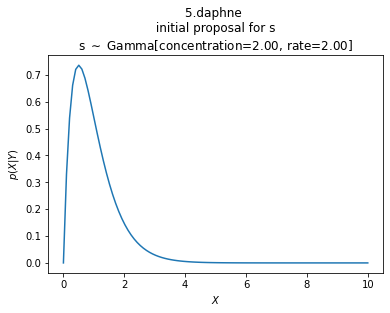

In [28]:
sr = pd.Series(pdf)
sr.index = support
sr.plot()

plt.xlabel('$X$')
plt.ylabel('$p(X|Y)$')
plt.title(\
          '{} \n initial proposal for s \n'.format(fname) +\
          's $\sim$ Gamma' +\
          '[concentration={:1.2f}, rate={:1.2f}]'.format(init_concentration,init_rate)
         )

In [7]:
%%time
T=5000
L=50
lr=0.05

r, logW, sigma = bbvi.graph_bbvi_algo12(graph,T=T,L=L,lr=lr,
                                        init_local_env={'prior_dist':{'sample2':d_init}},
                                        do_log=False)

t=0, Q after step={'sample2': Gamma(concentration: 2.049999952316284, rate: 1.8545866012573242), 'sample1': Normal(loc: 0.04999998211860657, scale: 4.993239402770996)}
t=500, Q after step={'sample2': Gamma(concentration: 3.5841071605682373, rate: 0.6521859765052795), 'sample1': Normal(loc: -0.03162112832069397, scale: 0.5565510988235474)}
t=1000, Q after step={'sample2': Gamma(concentration: 3.9007184505462646, rate: 0.4390002489089966), 'sample1': Normal(loc: -0.01562013104557991, scale: 0.20264212787151337)}
t=1500, Q after step={'sample2': Gamma(concentration: 3.9578874111175537, rate: 0.501619815826416), 'sample1': Normal(loc: 0.01076040044426918, scale: 0.15789341926574707)}
t=2000, Q after step={'sample2': Gamma(concentration: 4.0830841064453125, rate: 0.509914755821228), 'sample1': Normal(loc: 0.001771264709532261, scale: 0.16390740871429443)}
t=2500, Q after step={'sample2': Gamma(concentration: 4.188406944274902, rate: 0.5608922839164734), 'sample1': Normal(loc: -0.02664764598

Text(0.5, 1.0, '5.daphne  \n Best ELBO -11.25 \n T=5000 | L=50 | Adam, lr=0.05 ')

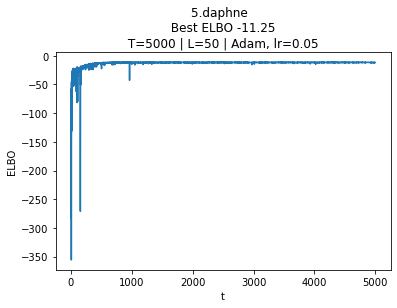

In [8]:
elbo = logW.mean(1)
pd.Series(elbo).plot()
plt.xlabel('t')
plt.ylabel('ELBO')
plt.title('{}  \n Best ELBO {:1.2f} \n T={} | L={} | Adam, lr={} '.format(fname,elbo.max(),T,L,lr))

Text(0.5, 1.0, '5.daphne  \n Best ELBO -11.25 \n T=5000 | L=50 | Adam, lr=0.05 ')

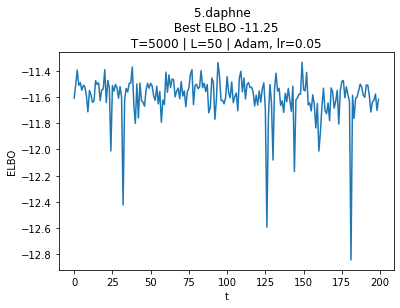

In [9]:
pd.Series(elbo[-200:]).plot()
plt.xlabel('t')
plt.ylabel('ELBO')
plt.title('{}  \n Best ELBO {:1.2f} \n T={} | L={} | Adam, lr={} '.format(fname,elbo.max(),T,L,lr))

In [10]:
r = np.array(r)

probs = np.exp(logW)
probs /= probs.sum()
posterior_r = (probs * r).sum()

posterior_r2 = (probs * r**2).sum()

std_r = np.sqrt(posterior_r2 - posterior_r**2)

In [11]:
print('{} posterior s {:1.3f} | std s {:1.3f}'.format(fname,posterior_r,std_r))

5.daphne posterior s 7.494 | std s 4.833


Interestingy we see that the best ELBO is not the final one. The size of the mini match L might affect the fluctuations of the ELBO over t...

Text(0.5, 1.0, '5.daphne  \n Trace \n T=5000 | L=50 | Adam, lr=0.05 ')

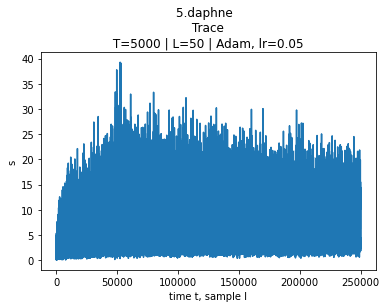

In [12]:
trace = r.flatten()
pd.Series(trace).plot()
plt.xlabel('time t, sample l')
plt.ylabel('s')
plt.title('{}  \n Trace \n T={} | L={} | Adam, lr={} '.format(fname,T,L,lr))

We can see here the samples in the tails of the posterior. The logW is very small for high s (e.g. 30-40+ range), and so the posterios probability is low in these regions.

Text(0.5, 1.0, '5.daphne \n posterior of s (learned proposal) \ns $\\sim$ Gamma[concentration=3.82, rate=0.51]')

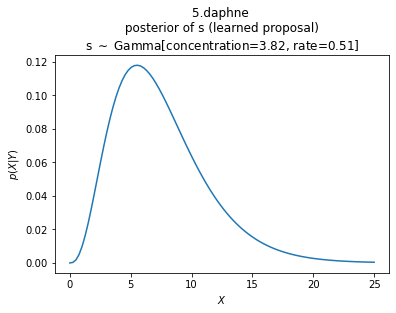

In [40]:
Q = sigma['Q_best_t']
q = Q['sample2']
learned_concentration = q.concentration.detach().numpy()
learned_rate = q.rate.detach().numpy()
support = np.linspace(1e-6,25,100)
log_pdf = np.zeros_like(support)

for idx,c in enumerate(support):
    log_pdf[idx] = q.log_prob(tensor(c))
pdf = np.exp(log_pdf)

pdf_scaled  = pdf / pdf.sum()

sr = pd.Series(pdf)
sr.index = support
sr.plot()

plt.xlabel('$X$')
plt.ylabel('$p(X|Y)$')
plt.title(\
          '{} \n posterior of s (learned proposal) \n'.format(fname) +\
          's $\sim$ Gamma' +\
          '[concentration={:1.2f}, rate={:1.2f}]'.format(learned_concentration,learned_rate)
         )

We can overlay the learned distribion on the empirical (binned) posterior, and compare (taking care to scale appropriately). Outliers with high enough logW in the sampling can shift the proposal. I think that having a different divergence than KL, perhaps that is more robust to outliers, would perhaps mitigate this. 


In [41]:
counts_bins = np.histogram(r.flatten(), weights=probs.flatten(), bins=200)
counts, bins = counts_bins[0], counts_bins[1]
idxs = (counts > counts.max()*0.005)

In [42]:
support = bins[1:][idxs]
log_pdf = np.zeros_like(support)

for idx,c in enumerate(support):
    log_pdf[idx] = q.log_prob(tensor(c))
pdf = np.exp(log_pdf)



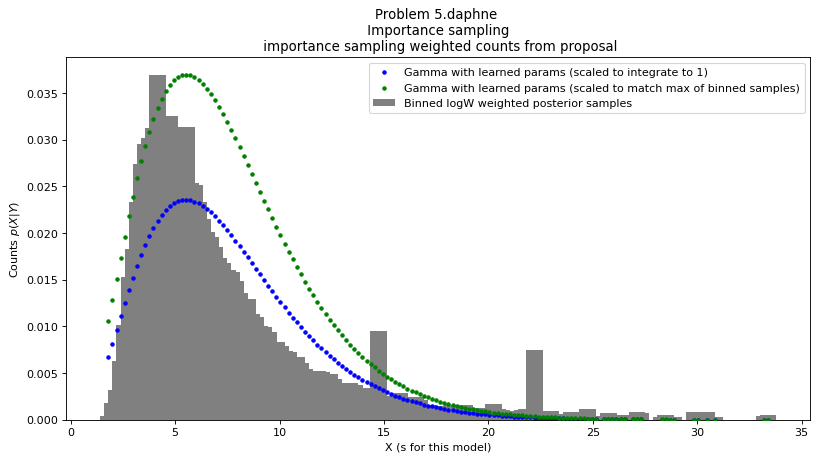

In [84]:
fig = plt.figure

fig(figsize=(12, 6), dpi=80)

axes = plt.bar(bins[1:][idxs],counts[idxs],color='gray',label='Binned logW weighted posterior samples')
plt.title('Problem {} \n Importance sampling \n importance sampling weighted counts from proposal'.format(fname))
plt.ylabel('Counts $p(X|Y)$')
plt.xlabel('X (s for this model)')

pdf_scaled  = pdf / pdf.sum() #* counts[idxs].max()
axes = plt.scatter(support,pdf_scaled,marker='.',zorder=2,color='blue',label='Gamma with learned params (scaled to integrate to 1)')

pdf_scaled_maxmatch  = pdf / pdf.max() * counts[idxs].max()
axes = plt.scatter(support,pdf_scaled_maxmatch,marker='.',zorder=3,color='green', label='Gamma with learned params (scaled to match max of binned samples)')

plt.legend(loc='best')

We can see how the samples that are outliers, around 15 and 22 push the proposal outward, away from matching the samples around ~2.5-10

In [17]:
gamma_analytic_mean = learned_concentration/learned_rate
print('posterior mean from sampling {:1.3f} \nanalytical mean of Gamma from fit proposal params {:1.3f}'.format(posterior_r, gamma_analytic_mean))

posterior mean from sampling 7.494 
analytical mean of Gamma from fit proposal params 7.471


In [18]:
gamma_analytic_std = np.sqrt(learned_concentration/learned_rate**2)
gamma_analytic_mean = learned_concentration/learned_rate
print('posterior std from sampling {:1.3f} \nanalytical std of Gamma from fit proposal params {:1.3f}'.format(std_r,gamma_analytic_std))

posterior std from sampling 4.833 
analytical std of Gamma from fit proposal params 3.823


If we inspect the program, we can reason that the `s` will be drawn from a uniform distribution with a low of 0.01 and a high of any positive number (abs m), but values given by a normal centred at zero and a spread of std=5. Visually, `s` is drawn from a bunch of uniforms that are all starting at 0.01 and go further and further out with less and less probability. Thus there will be a hump where many of the samples will be drawn from, and then decreased probability.

I chose to propose Gamma for this, since it has a hump, and is supported on the positive real line. 

Note that there is some probability in the posterior that we have `s` < 0.01, whereas the true posterior has zero probability here. The parameters of Gamma can learn this, because it has enough flexibility to allow this. The learned posterior has very minimal probability for `s` < 0.01, and the little it does have is one reason why the elbo doesn't get driven completely to zero.

Programatically, we would like to keep track of the support of s form the program, and choose a distribution that matches this and has some flexibility to drive the KL near zero.

For instance, in Pyrro, there is an affine beta distribution, where the support is in between high and low, instead of 0 and 1. We could imaging an shifted "Gamma", "Gamma"_shifted = shift + Gamma_unshifted

In general, we have to choose a proposal that has enough support for its random variable. The support of the proposal will always be as much or larger than the support of this random variable in the true posterior. Thus in general, BBVI will overestimate the support. See the remarks on this in [Stefano Ermon's Probabilistic Graphical Models Winter class (Stanford 2020-21)](https://ermongroup.github.io/cs228-notes/inference/variational/)

